In [8]:
import os
import tqdm
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import kagglehub

In [9]:
def set_seeds(seed):
    """Sets the seed for reproducible results across different libraries."""
    random.seed(seed) # Python's built-in random
    np.random.seed(seed) # NumPy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # PyTorch CUDA for all available GPUs
        # Optional: Additional settings for full CUDA reproducibility
        # Note: These might slow down execution
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

def write_to_disk(unet, path):
    unet.save_pretrained(path)
    print(f"Unet saved to {path}")

def load_from_disk(model_class, path):
    model = model_class.from_pretrained(path)

    # You can still calculate parameters if needed after loading
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model

In [10]:
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/amcalinden/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7


In [11]:
path_train = os.path.join(path, "train")
outer_dir = os.listdir(path_train)
print("Num Classes:", len(outer_dir))
classes = []
for subfolder in outer_dir:
    subfolder_path = os.path.join(path_train, subfolder)
    if os.path.isdir(subfolder_path):
        inner_size = len(os.listdir(subfolder_path))
        classes.append((inner_size, subfolder))
classes.sort(reverse=True)
print("Classes sorted by number of images:")
for size, name in classes:
    print(f"  {name}: {size} images")

Num Classes: 80
Classes sorted by number of images:
  Butterfly: 1876 images
  Moths and butterflies: 1430 images
  Lizard: 1201 images
  Spider: 857 images
  Fish: 836 images
  Monkey: 771 images
  Eagle: 720 images
  Frog: 589 images
  Snake: 563 images
  Duck: 543 images
  Caterpillar: 495 images
  Sparrow: 476 images
  Jellyfish: 458 images
  Parrot: 422 images
  Owl: 407 images
  Horse: 401 images
  Ladybug: 393 images
  Tortoise: 392 images
  Chicken: 389 images
  Penguin: 378 images
  Snail: 371 images
  Squirrel: 368 images
  Deer: 328 images
  Tiger: 314 images
  Crab: 310 images
  Shark: 304 images
  Giraffe: 299 images
  Goose: 290 images
  Whale: 288 images
  Starfish: 249 images
  Harbor seal: 241 images
  Sea turtle: 240 images
  Swan: 234 images
  Polar bear: 230 images
  Rabbit: 217 images
  Rhinoceros: 215 images
  Lion: 209 images
  Goat: 203 images
  Centipede: 195 images
  Pig: 191 images
  Sea lion: 189 images
  Zebra: 182 images
  Woodpecker: 172 images
  Elephant

In [12]:
from dataclasses import dataclass

@dataclass
class Hyperparameters:
    image_size = 128
    num_classes = 11
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 32
    num_ddpm_steps = 1000
    num_epochs = 60
    lr = 1e-4
    num_warmup_steps = 500
    scale_factor= 0.18215
    seed = 423432

config = Hyperparameters()
set_seeds(config.seed)

Random seed set to 423432


In [13]:
top_classes = [tup[1] for tup in classes[:config.num_classes]]
print("Using classes:", top_classes)

Using classes: ['Butterfly', 'Moths and butterflies', 'Lizard', 'Spider', 'Fish', 'Monkey', 'Eagle', 'Frog', 'Snake', 'Duck', 'Caterpillar']


In [14]:
import AnimalDataset
from torch.utils.data import DataLoader

import importlib
importlib.reload(AnimalDataset)

print("Using device:", config.device)
dataset = AnimalDataset.AnimalDataset(path_train, top_classes, config.image_size, config.device)
train_loader = DataLoader(
    dataset,
    config.batch_size,
    shuffle=True,
)

Using device: cuda:0


Image shape: torch.Size([32, 3, 128, 128])
Embedding shape: torch.Size([32, 1, 768])


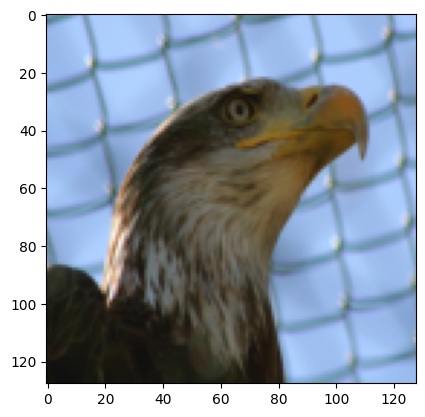

In [15]:
for img, embedding in train_loader:
    print("Image shape:", img.shape)
    print("Embedding shape:", embedding.shape)
    img_show = (img + 1) / 2
    plt.imshow(img_show[0].permute(1, 2, 0).cpu())
    plt.show()
    break

In [22]:
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler

# same as the one used in stable diffusion
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32)
vae.eval()
vae.requires_grad_(False)
vae.to(config.device)

unet = UNet2DConditionModel(cross_attention_dim = (768),
                                    down_block_types = ("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
                                    block_out_channels= (320, 640, 1280),
                                    up_block_types = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
                                    ).to(torch.float32)
unet.requires_grad_(True)
unet.to(config.device)

total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_ddpm_steps)

Total parameters: 446,450,884
Trainable parameters: 446,450,884


In [14]:
import torch.nn.functional as F
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.num_warmup_steps,
    num_training_steps=(len(train_loader) * config.num_epochs),
)

In [43]:
def train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler, start_epoch=0):
    vae.eval()
    unet.train()

    losses = []
    for epoch in range(start_epoch, start_epoch + config.num_epochs):
        total_loss = 0
        for imgs, embeddings in tqdm.tqdm(train_loader):
            imgs = imgs.to(config.device)
            embeddings = embeddings.to(config.device)

            with torch.no_grad():
                latents = vae.encode(imgs).latent_dist.sample()
                latents *= config.scale_factor

            batch_size = imgs.shape[0]
            noise = torch.randn(latents.shape).to(config.device)
            timesteps = torch.randint(0, config.num_ddpm_steps, (batch_size,)).to(config.device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings.detach()).sample

            loss = F.mse_loss(model_pred, noise, reduction="mean")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()

            del loss, model_pred, noisy_latents, noise, timesteps, latents
            torch.cuda.empty_cache()


        print(f"Epoch {epoch + 1}/{config.num_epochs + start_epoch}, Loss: {total_loss / len(train_loader)}")
        losses.append(total_loss / len(train_loader))
    return losses

In [44]:
losses = train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler)

100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 1/60, Loss: 0.31313446976702575


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 2/60, Loss: 0.19225367520330022


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 3/60, Loss: 0.18329809946053235


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 4/60, Loss: 0.18149504612853998


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 5/60, Loss: 0.18065978323853904


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 6/60, Loss: 0.17888466140984718


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 7/60, Loss: 0.17416849199525747


100%|██████████| 309/309 [03:30<00:00,  1.47it/s]


Epoch 8/60, Loss: 0.17519982419546368


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 9/60, Loss: 0.17498355305792831


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 10/60, Loss: 0.17003763124684299


100%|██████████| 309/309 [10:07<00:00,  1.96s/it]


Epoch 11/60, Loss: 0.17132263037475567


100%|██████████| 309/309 [03:38<00:00,  1.41it/s]


Epoch 12/60, Loss: 0.16655984985066463


100%|██████████| 309/309 [10:23<00:00,  2.02s/it]


Epoch 13/60, Loss: 0.16714434899558528


100%|██████████| 309/309 [03:32<00:00,  1.45it/s]


Epoch 14/60, Loss: 0.17045909262783704


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 15/60, Loss: 0.17042853432469385


100%|██████████| 309/309 [03:35<00:00,  1.43it/s]


Epoch 16/60, Loss: 0.1674898158409256


100%|██████████| 309/309 [03:30<00:00,  1.46it/s]


Epoch 17/60, Loss: 0.16538316370696313


100%|██████████| 309/309 [04:39<00:00,  1.10it/s]


Epoch 18/60, Loss: 0.16534836067061595


100%|██████████| 309/309 [03:39<00:00,  1.41it/s]


Epoch 19/60, Loss: 0.16210325961649225


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 20/60, Loss: 0.16656878891982693


100%|██████████| 309/309 [10:08<00:00,  1.97s/it]


Epoch 21/60, Loss: 0.1594952807119749


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 22/60, Loss: 0.17109579768960145


100%|██████████| 309/309 [03:41<00:00,  1.40it/s]


Epoch 23/60, Loss: 0.16608615998407783


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 24/60, Loss: 0.16228595583377148


100%|██████████| 309/309 [03:32<00:00,  1.46it/s]


Epoch 25/60, Loss: 0.16224878131861054


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 26/60, Loss: 0.16181708085064364


100%|██████████| 309/309 [03:30<00:00,  1.47it/s]


Epoch 27/60, Loss: 0.15995139165700062


100%|██████████| 309/309 [03:42<00:00,  1.39it/s]


Epoch 28/60, Loss: 0.16457636010588952


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 29/60, Loss: 0.16001953701805144


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 30/60, Loss: 0.16151365061504555


100%|██████████| 309/309 [03:30<00:00,  1.46it/s]


Epoch 31/60, Loss: 0.16092585227346728


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 32/60, Loss: 0.16281746462903748


100%|██████████| 309/309 [03:34<00:00,  1.44it/s]


Epoch 33/60, Loss: 0.15897896408456044


100%|██████████| 309/309 [03:29<00:00,  1.47it/s]


Epoch 34/60, Loss: 0.16303568945829922


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 35/60, Loss: 0.16520781523297906


100%|██████████| 309/309 [03:41<00:00,  1.39it/s]


Epoch 36/60, Loss: 0.1575069802551015


100%|██████████| 309/309 [03:29<00:00,  1.47it/s]


Epoch 37/60, Loss: 0.16137309623188956


100%|██████████| 309/309 [03:32<00:00,  1.46it/s]


Epoch 38/60, Loss: 0.15972168623050825


100%|██████████| 309/309 [03:29<00:00,  1.47it/s]


Epoch 39/60, Loss: 0.16169660895291268


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 40/60, Loss: 0.1625747873077115


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 41/60, Loss: 0.1620387540328464


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 42/60, Loss: 0.15941109965196706


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 43/60, Loss: 0.15957232106561414


100%|██████████| 309/309 [03:32<00:00,  1.45it/s]


Epoch 44/60, Loss: 0.16028145001447702


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 45/60, Loss: 0.1588895173809675


100%|██████████| 309/309 [03:32<00:00,  1.45it/s]


Epoch 46/60, Loss: 0.15809828167160353


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 47/60, Loss: 0.1563334674559365


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 48/60, Loss: 0.16090442647729492


100%|██████████| 309/309 [03:36<00:00,  1.43it/s]


Epoch 49/60, Loss: 0.15475499998886608


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 50/60, Loss: 0.15977032286111978


100%|██████████| 309/309 [03:35<00:00,  1.44it/s]


Epoch 51/60, Loss: 0.15927519226103154


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 52/60, Loss: 0.15718607711801638


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 53/60, Loss: 0.15760350963974848


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 54/60, Loss: 0.15457883902786232


100%|██████████| 309/309 [03:26<00:00,  1.49it/s]


Epoch 55/60, Loss: 0.16004539814003077


100%|██████████| 309/309 [03:25<00:00,  1.51it/s]


Epoch 56/60, Loss: 0.15973157698475426


100%|██████████| 309/309 [03:34<00:00,  1.44it/s]


Epoch 57/60, Loss: 0.15928141278452856


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 58/60, Loss: 0.15697187127418888


100%|██████████| 309/309 [03:29<00:00,  1.48it/s]


Epoch 59/60, Loss: 0.15457775120692732


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]

Epoch 60/60, Loss: 0.1556079493636645


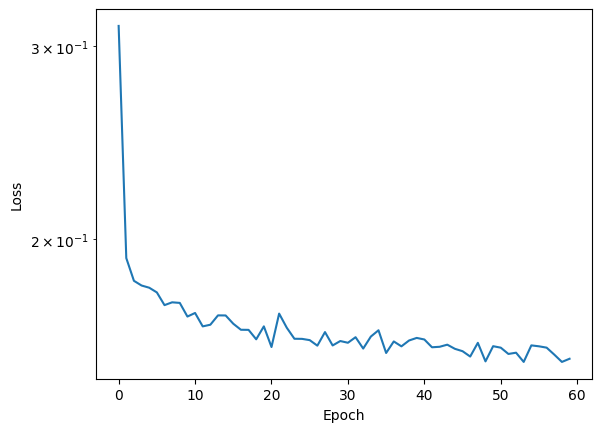

In [45]:
def plot_losses(losses):
    plt.semilogy(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
plot_losses(losses)

100%|██████████| 309/309 [03:34<00:00,  1.44it/s]


Epoch 61/120, Loss: 0.16131422786843816


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 62/120, Loss: 0.15269830419070127


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 63/120, Loss: 0.15654241244239328


100%|██████████| 309/309 [03:32<00:00,  1.45it/s]


Epoch 64/120, Loss: 0.15973640857776777


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 65/120, Loss: 0.15731166395988666


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 66/120, Loss: 0.1597302215577715


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 67/120, Loss: 0.1555187318558446


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 68/120, Loss: 0.1584344856730364


100%|██████████| 309/309 [03:34<00:00,  1.44it/s]


Epoch 69/120, Loss: 0.15311078434285608


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 70/120, Loss: 0.1559795007398985


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 71/120, Loss: 0.15684992574082995


100%|██████████| 309/309 [03:40<00:00,  1.40it/s]


Epoch 72/120, Loss: 0.15580477417238708


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 73/120, Loss: 0.15523738530991918


100%|██████████| 309/309 [03:36<00:00,  1.43it/s]


Epoch 74/120, Loss: 0.1620204119813481


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 75/120, Loss: 0.15742578757715842


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 76/120, Loss: 0.15780821921225505


100%|██████████| 309/309 [03:40<00:00,  1.40it/s]


Epoch 77/120, Loss: 0.1574252399233167


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 78/120, Loss: 0.15939297553597917


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 79/120, Loss: 0.15542096937599692


100%|██████████| 309/309 [03:35<00:00,  1.43it/s]


Epoch 80/120, Loss: 0.1588015419138674


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 81/120, Loss: 0.15540561513993348


100%|██████████| 309/309 [03:35<00:00,  1.44it/s]


Epoch 82/120, Loss: 0.15818159747567379


100%|██████████| 309/309 [03:28<00:00,  1.48it/s]


Epoch 83/120, Loss: 0.16176107005008217


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 84/120, Loss: 0.15941723577171854


100%|██████████| 309/309 [03:30<00:00,  1.46it/s]


Epoch 85/120, Loss: 0.15767921693020268


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 86/120, Loss: 0.1568905339850577


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 87/120, Loss: 0.16789369808335133


100%|██████████| 309/309 [03:30<00:00,  1.47it/s]


Epoch 88/120, Loss: 0.16096970530582477


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 89/120, Loss: 0.16022756715036904


100%|██████████| 309/309 [03:25<00:00,  1.51it/s]


Epoch 90/120, Loss: 0.1599865071113827


100%|██████████| 309/309 [03:29<00:00,  1.48it/s]


Epoch 91/120, Loss: 0.1588025031111001


100%|██████████| 309/309 [03:22<00:00,  1.52it/s]


Epoch 92/120, Loss: 0.16148626786267872


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 93/120, Loss: 0.15938557100913286


100%|██████████| 309/309 [03:33<00:00,  1.45it/s]


Epoch 94/120, Loss: 0.15651152037011767


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 95/120, Loss: 0.15954618890163969


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 96/120, Loss: 0.1638149348325714


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 97/120, Loss: 0.15709540849509362


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 98/120, Loss: 0.1580070839971786


100%|██████████| 309/309 [03:29<00:00,  1.48it/s]


Epoch 99/120, Loss: 0.15751382149153156


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 100/120, Loss: 0.15897781133024824


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 101/120, Loss: 0.1605609315763978


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 102/120, Loss: 0.1637928906623214


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 103/120, Loss: 0.15926324173470532


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 104/120, Loss: 0.15874300393182483


100%|██████████| 309/309 [03:30<00:00,  1.47it/s]


Epoch 105/120, Loss: 0.15799269099451577


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 106/120, Loss: 0.16167730187038773


100%|██████████| 309/309 [03:32<00:00,  1.46it/s]


Epoch 107/120, Loss: 0.15967824228083818


100%|██████████| 309/309 [03:26<00:00,  1.50it/s]


Epoch 108/120, Loss: 0.15958546208139376


100%|██████████| 309/309 [03:25<00:00,  1.50it/s]


Epoch 109/120, Loss: 0.16380823924414162


100%|██████████| 309/309 [03:31<00:00,  1.46it/s]


Epoch 110/120, Loss: 0.16108747987637242


100%|██████████| 309/309 [03:23<00:00,  1.51it/s]


Epoch 111/120, Loss: 0.16046669688618298


100%|██████████| 309/309 [03:24<00:00,  1.51it/s]


Epoch 112/120, Loss: 0.15973997382525487


100%|██████████| 309/309 [03:32<00:00,  1.46it/s]


Epoch 113/120, Loss: 0.15788998616358996


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 114/120, Loss: 0.15700848556114633


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 115/120, Loss: 0.1636295049876264


100%|██████████| 309/309 [03:30<00:00,  1.47it/s]


Epoch 116/120, Loss: 0.1626607565070626


100%|██████████| 309/309 [03:22<00:00,  1.53it/s]


Epoch 117/120, Loss: 0.16187431505341746


100%|██████████| 309/309 [03:23<00:00,  1.52it/s]


Epoch 118/120, Loss: 0.16373898943699294


100%|██████████| 309/309 [03:27<00:00,  1.49it/s]


Epoch 119/120, Loss: 0.16404403789529523


100%|██████████| 309/309 [03:22<00:00,  1.52it/s]

Epoch 120/120, Loss: 0.16110659964551433


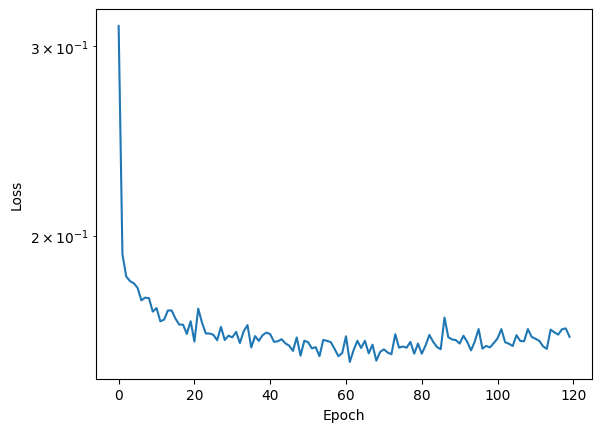

In [55]:
losses_2 = train_model(config, train_loader, vae, unet, noise_scheduler, optimizer, lr_scheduler, start_epoch=config.num_epochs)
full_losses = losses + losses_2
plot_losses(full_losses)

In [25]:
latent_shape = None
for imgs, embeddings in train_loader:
    imgs = imgs.to(config.device)
    embeddings = embeddings.to(config.device)
    latent = vae.encode(imgs).latent_dist.sample()
    latent_shape = latent.shape
    break
print("Latent shape:", latent_shape)

Latent shape: torch.Size([32, 4, 16, 16])


In [20]:
def sample_from_model(config, vae, unet, noise_scheduler, text_embedding, latent_shape, num_samples=20):
    vae.eval()
    unet.eval()

    if len(text_embedding.shape) < 3: 
        text_embedding = text_embedding.unsqueeze(0)
    text_embedding = text_embedding.expand(num_samples, -1, -1)

    latent_shape = torch.Size((num_samples,) + latent_shape[1:])
    latents = torch.randn(latent_shape).to(config.device)
    # latents *= config.scale_factor

    with torch.no_grad():
        for i in noise_scheduler.timesteps:
            # latent_inputs = noise_scheduler.scale_model_input(latents, i)
            model_pred = unet(latents, i, encoder_hidden_states=text_embedding).sample
            latents = noise_scheduler.step(model_pred, i, latents).prev_sample
        images = vae.decode(latents / config.scale_factor).sample
        images = (images / 2) + 0.5
        images = torch.clamp(images, 0, 1)
        return images

In [27]:
def make_grid(images, ncols=4):
    n = len(images)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()
    for i in range(n):
        axs[i].imshow(images[i].permute(1, 2, 0).cpu())
        axs[i].axis("off")
    for i in range(n, nrows * ncols):
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

Sampling images for class: Butterfly
Sampling images for class: Moths and butterflies
Sampling images for class: Lizard
Sampling images for class: Spider
Sampling images for class: Fish
Sampling images for class: Monkey
Sampling images for class: Eagle
Sampling images for class: Frog
Sampling images for class: Snake
Sampling images for class: Duck
Sampling images for class: Caterpillar


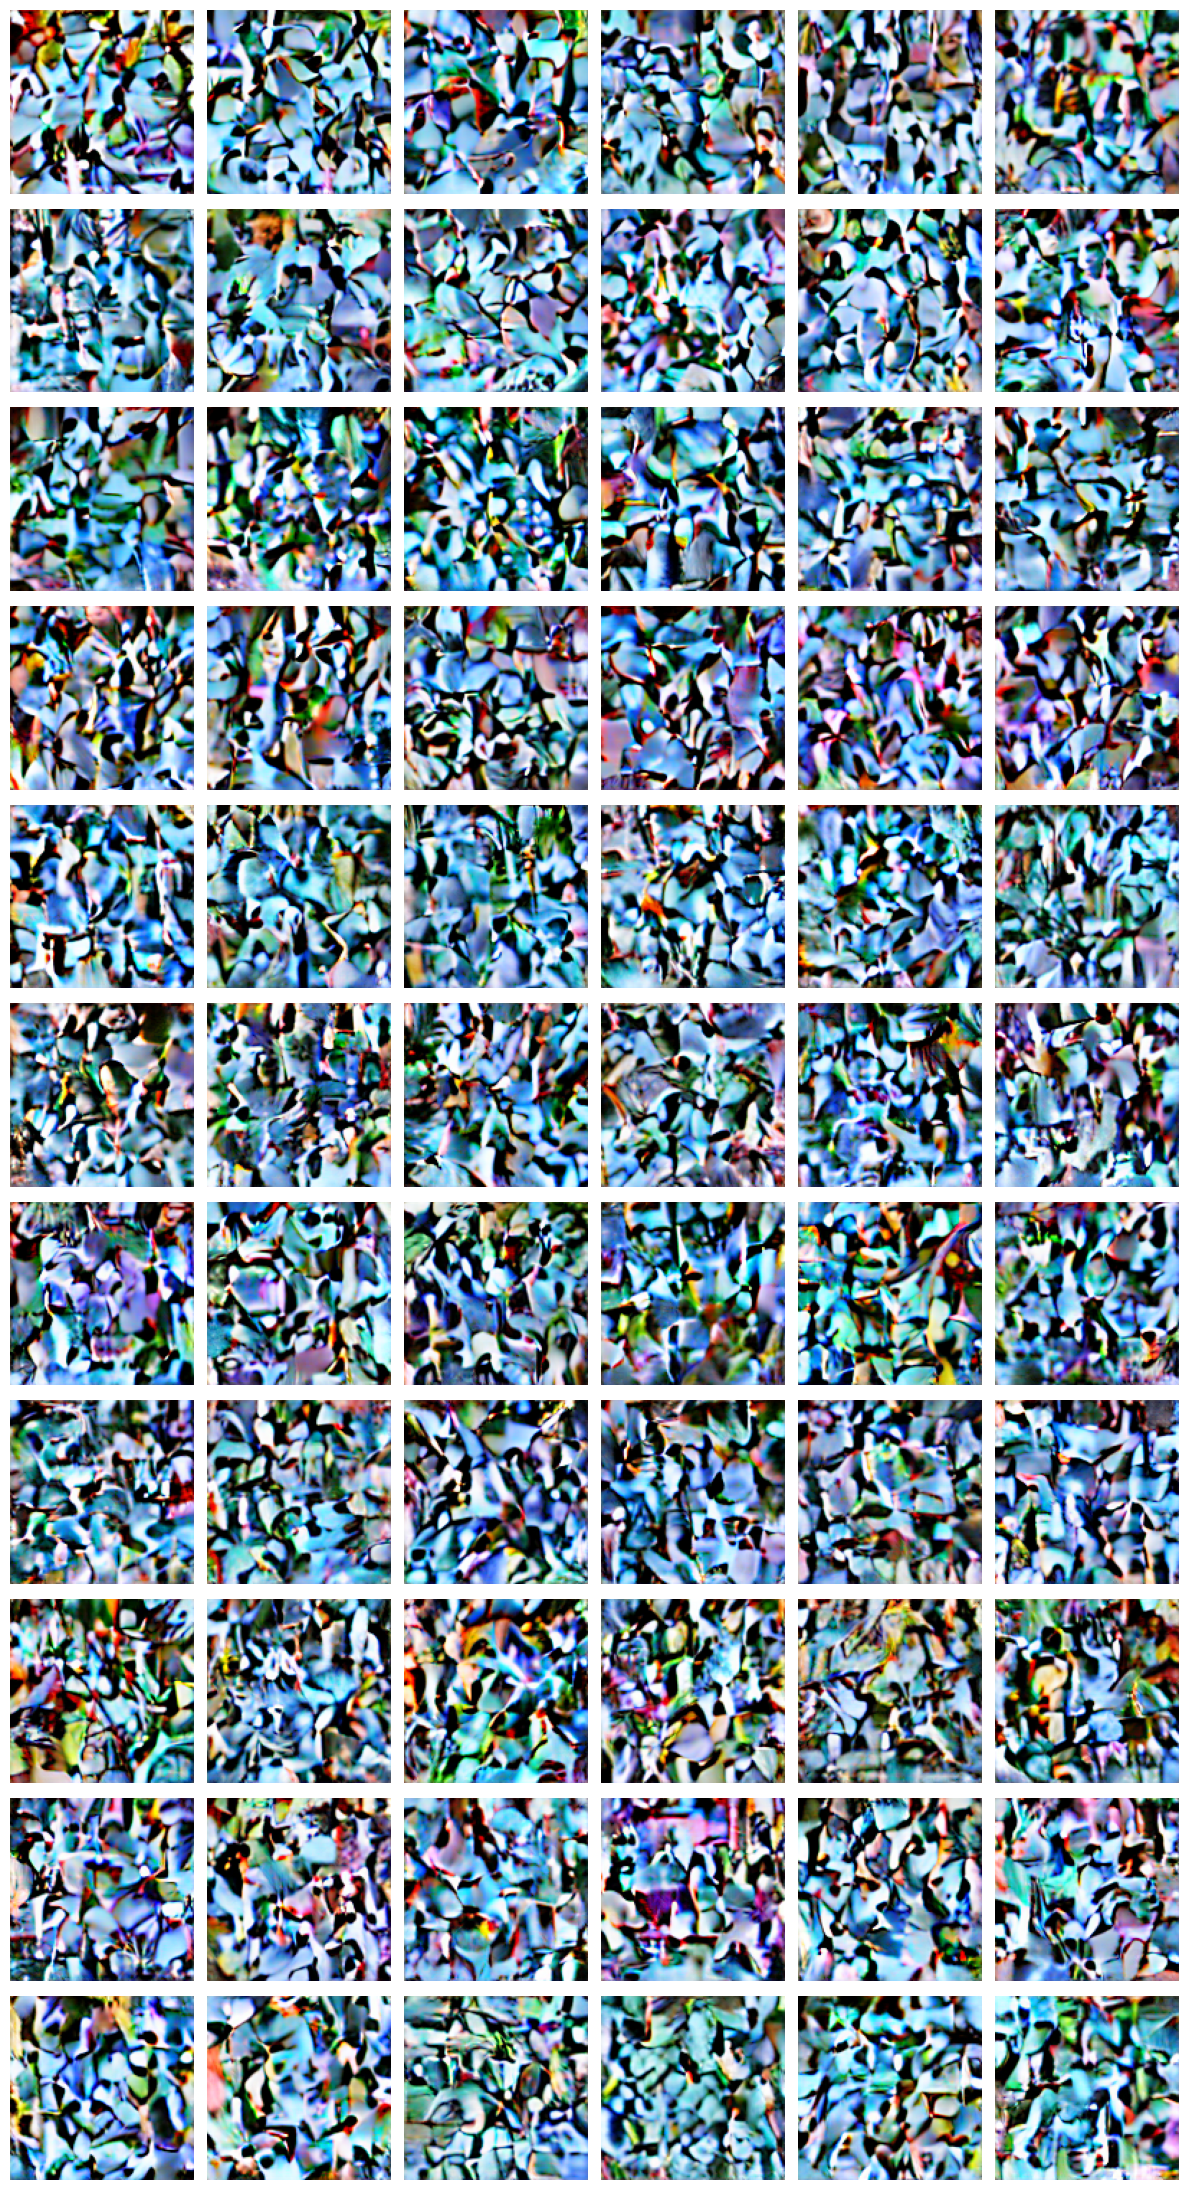

In [18]:
all_samples = []
cols = 6
for num_images, text in classes[:config.num_classes]:
    print("Sampling images for class:", text)
    embedding = dataset.label_to_text_embedding[text]
    samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
    all_samples += samples
make_grid(all_samples, ncols=cols)

In [ ]:
# write_to_disk(unet, "top10_400m_120epoch_batch32")

Sampling images for class: Salamander


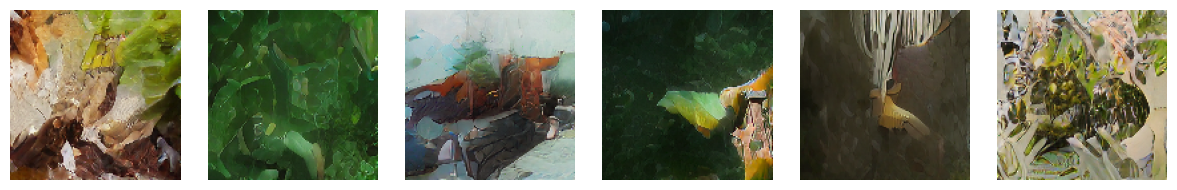

In [15]:
text = "Salamander"
cols = 6
print("Sampling images for class:", text)
embedding = dataset.get_embedding(text)
samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
make_grid(samples, ncols=cols)

In [23]:
unet = load_from_disk(UNet2DConditionModel, "top10_400m_60epoch")
unet.to(config.device)

Total parameters: 446,450,884
Trainable parameters: 446,450,884


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

Sampling images for class: Eagle


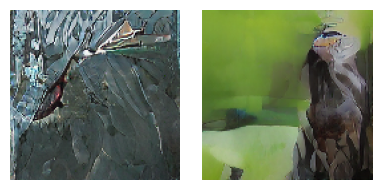

In [28]:
attn_blocks = []
for block in unet.down_blocks:
    if hasattr(block, "attentions"):
        for attn in block.attentions:
            if hasattr(attn, "transformer_blocks"):
                attn_blocks.extend(attn.transformer_blocks)

first_block = attn_blocks[0]  # <- First BasicTransformerBlock

# register a hook
attn_outputs = []

def save_attn_output(module, input, output):
    attn_outputs.append(output)

hook_handle = first_block.register_forward_hook(save_attn_output)

text = "Eagle"
cols = 2
print("Sampling images for class:", text)
embedding = dataset.get_embedding(text)
samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=cols)
make_grid(samples, ncols=cols)

hook_handle.remove()

torch.Size([2, 256, 320])


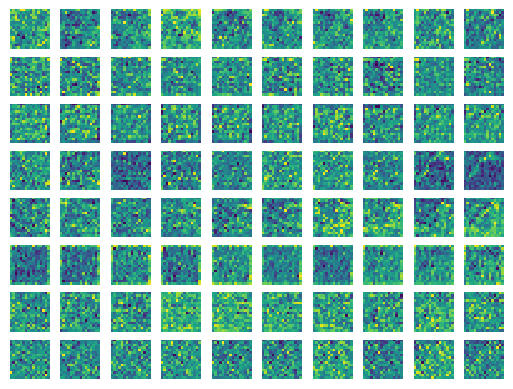

In [29]:
print(attn_outputs[-1].shape)
steps = len(attn_outputs)
nheads = 8
fig, axs = plt.subplots(nheads, 10)
skip = steps // 10
for r in range(nheads):
    for c in range(10):
        curr = attn_outputs[c*skip][0].detach().cpu()
        curr = curr.reshape(256, nheads, -1)
        curr = curr.mean(dim = -1)

        axs[r,c].matshow(curr[:,r].reshape(16, 16))
        axs[r,c].axis('off')

## Evaluations: FIP ##

In [31]:
from torchvision.utils import save_image

count = 1
os.makedirs('real_images', exist_ok=True)
os.makedirs('fake_images', exist_ok=True)

for imgs, embeddings in tqdm.tqdm(train_loader):
    if count == 0:
        break
    count -=1
    embeddings = embeddings.to(config.device)
    bs = embeddings.shape[0]
    samples = sample_from_model(config, vae, unet, noise_scheduler, embedding, latent_shape, num_samples=bs).detach().cpu()
    for i, img in enumerate(imgs):
        save_image(img, f'real_images/{count}_{i:04d}.png')

    for i, img in enumerate(samples):
        save_image(img, f'fake_images/{count}_{i:04d}.png')

  0%|          | 1/309 [00:46<3:59:48, 46.72s/it]


In [32]:
from PIL import Image
import torchvision.transforms as transforms
to_tensor = transforms.ToTensor()

real_dir = 'real_images'
fake_dir = 'fake_images'

real_image_batch = []
for real_img_path in os.listdir(real_dir):
    image = Image.open(os.path.join(real_dir, real_img_path))
    image_tensor = to_tensor(image)
    real_image_batch.append(image_tensor)

fake_image_batch = []
for fake_img_path in os.listdir(fake_dir):
    image = Image.open(os.path.join(fake_dir, fake_img_path))
    image_tensor = to_tensor(image)
    fake_image_batch.append(image_tensor)

real_image_batch = torch.stack(real_image_batch)
fake_image_batch = torch.stack(fake_image_batch)

In [37]:
from inception_v3_feature_extractor import InceptionV3FeatureExtractor
extractor = InceptionV3FeatureExtractor()
print(real_image_batch.shape)
real_features = extractor(real_image_batch)
fake_features = extractor(fake_image_batch)
print(real_features.shape)


torch.Size([64, 3, 128, 128])
torch.Size([64, 2048])


In [ ]:
import numpy as np

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    a = (mu1 - mu2).square().sum(dim=-1)
    b = sigma1.trace() + sigma2.trace()
    c = torch.linalg.eigvals(sigma1 @ sigma2).sqrt().real.sum(dim=-1)
    return a + b - 2 * c

def compute_statistics(features):
    mu = features.mean(dim = 0)
    sigma = torch.from_numpy(np.cov(features.numpy(), rowvar=False))
    return mu, sigma

mu_real, sigma_real = compute_statistics(real_features)
mu_fake, sigma_fake = compute_statistics(fake_features)

fid_value = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID: {fid_value}")

FID: 293.1622977542146


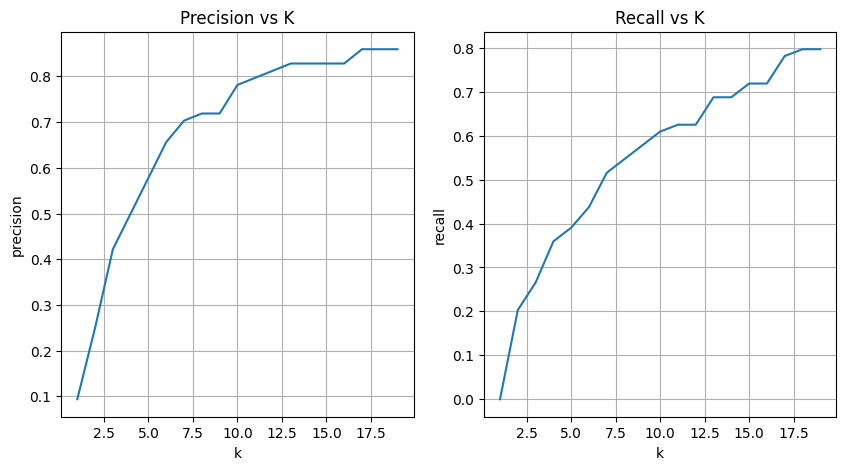

In [39]:
def f_dist(lhs_features, rhs_features, k=3):
    rhs_to_rhs = torch.cdist(rhs_features, rhs_features)
    lhs_to_rhs = torch.cdist(lhs_features, rhs_features)

    rhs_to_rhs[rhs_to_rhs == 0] = float('inf')  # Set diagonals to inf
    thresh = rhs_to_rhs.topk(k, largest=False).values[:, -1]  # (num_rhs,) vector of the kth distances
    ans = 0
    for row in lhs_to_rhs:
        if ((row <= thresh).any()):
            ans += 1
    return ans

precisions = []
recalls = []
for k in range(1, 20):
    precisions.append(f_dist(fake_features, real_features, k)/fake_features.shape[0])
    recalls.append(f_dist(real_features, fake_features, k)/real_features.shape[0])

x = range(1, len(precisions) + 1)
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].plot(x, precisions)
axs[0].set_xlabel('k')
axs[0].set_ylabel('precision')
axs[0].set_title('Precision vs K')
axs[0].grid(True)

axs[1].plot(x, recalls)
axs[1].set_xlabel('k')
axs[1].set_ylabel('recall')
axs[1].set_title('Recall vs K')
axs[1].grid(True)